In [90]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [91]:
a = np.array([0, 1, 2])
b = np.array([3, 4, 5])
c = np.concatenate((a, b))
print(c)

[0 1 2 3 4 5]


In [92]:
#Função Sphere
def sphere(vetor, limite_inferior=-100, limite_superior=100):
  resultado = 0
  
  for i in vetor:
    resultado += i**2
  
  return resultado

#Função rastrigin
def rastrigin(vetor, limite_inferior=-30, limite_superior=30):
  resultado = 0
  
  for i in vetor:
    x = 2*math.pi*i
    resultado += 10 + ((i**2) - 10 * math.cos(x))
    

  return resultado 

#Função rosenbrock
def rosenbrock(vetor, limite_inferior=-5.12, limite_superior=5.12):
  resultado = 0
  
  for i in range(0,(len(vetor)-1)):
    resultado += 100*(vetor[i+1] - vetor[i]**2)**2 + (vetor[i] - 1)**2
    
  return resultado

In [93]:
class Inercia(Enum):
    CONSTANTE = 0
    DECAIMENTO_LINEAR = 1

In [94]:
class Cooperacao(Enum):
    GLOBAL = 0
    LOCAL_GEOGRAFICA = 1
    LOCAL_SOCIAL = 2

In [95]:
# FALTA

class AlgoritmoEnxameParticulas:
    def __init__(self, funcao, limite_funcao, limite_velocidade, limite_posicao, w_tipo, tipo_cooperacao, qtd_conexoes=0, dimensao=3, qtd_particulas=30, qtd_iteracoes=50, w_valor=1, w_max=1, w_min=0.8, c1=2.05, c2=2.05, tipo_problema=float):
        self.funcao = funcao
        self.limite_funcao = limite_funcao
        self.limite_velocidade = limite_velocidade
        self.limite_posicao = limite_posicao
        self.dimensao = dimensao
        self.qtd_particulas = qtd_particulas
        self.qtd_iteracoes = qtd_iteracoes 
        self.w_tipo = w_tipo
        self.w_valor = w_valor 
        self.w_max = w_max
        self.w_min = w_min
        self.c1 = c1
        self.c2 = c2
        self.tipo_cooperacao = tipo_cooperacao
        self.qtd_conexoes = qtd_conexoes
        self.tipo_problema = tipo_problema
        self.velocidade_particulas = self.gerar_parametros_iniciais(tipo_problema, limite_velocidade[0], limite_velocidade[1]) 
        self.posicao_particulas = self.gerar_parametros_iniciais(tipo_problema, limite_posicao[0], limite_posicao[1])
        self.melhores_cooperacao = []
        self.melhores_pessoais = []
        self.melhores_fitness = [] ## Esse é o histórico de fitness
        self.fitness_iteracao_anterior = [] 

    def otimizar(self):
        for i in range(self.qtd_iteracoes):
            self.cooperar(i, self.qtd_conexoes, self.calcular_fitness(self.posicao_particulas))
            self.calcular_melhor_pessoal(i, self.calcular_fitness(self.posicao_particulas), self.fitness_iteracao_anterior)
            self.atualizar_velocidades(self.velocidade_particulas, self.melhores_pessoais, self.melhores_cooperacao, i)
            self.atualizar_posicoes(self.velocidade_particulas)
            self.puxar_particulas(self.posicao_particulas, self.limite_posicao[0], self.limite_posicao[1])
            if (i == self.qtd_iteracoes - 1):
                print(f"Iteração {i+1} | Melhor solução: {self.obter_melhor_global(self.melhores_cooperacao)} | Fitness: {np.min(self.melhores_fitness)} | Histórico Fitness: {self.melhores_fitness}")
    
    def gerar_parametros_iniciais(self, tipo, limite_inferior, limite_superior):
        if (tipo == float):
            return np.random.uniform(low=limite_inferior, high=limite_superior, size=(self.qtd_particulas, self.dimensao))
        elif (tipo == int):
            return np.random.randint(low=limite_inferior, high=limite_superior, size=(self.qtd_particulas, self.dimensao))

    def calcular_fitness(self, particulas):
        return np.array([self.funcao(particula) for particula in self.posicao_particulas])
    
    def cooperar(self, numero_iteracao, qtd_conexoes, fitness_atual): 
        if (numero_iteracao == 0):
            self.melhores_cooperacao = self.posicao_particulas.copy()
        if (self.tipo_cooperacao == Cooperacao.LOCAL_GEOGRAFICA):
            resultado_div_dois = qtd_conexoes // 2
            resto_div_dois = qtd_conexoes - resultado_div_dois
            for i in range(self.qtd_particulas):
                if (i - resultado_div_dois < 0):                    
                    fitness_vizinhos = np.concatenate((fitness_atual[:i], fitness_atual[i:i+(qtd_conexoes-i)+1])) if i > 0 else fitness_atual[i:i+(qtd_conexoes-i)+1]
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)]
                elif (i + resto_div_dois > self.qtd_particulas-1):
                    inicio_final = i-(qtd_conexoes-(self.qtd_particulas-i-1))
                    fitness_vizinhos = np.concatenate((fitness_atual[inicio_final:i], fitness_atual[i:]))
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)+inicio_final]
                else:
                    inicio_meio = i-resultado_div_dois
                    fitness_vizinhos = fitness_atual[inicio_meio:i+resto_div_dois+1] 
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)+inicio_meio]
        elif (self.tipo_cooperacao == Cooperacao.LOCAL_SOCIAL):
            for i in range(self.qtd_particulas):
                indices_particulas_sociais = np.random.randint(low=0, high=self.qtd_particulas, size=qtd_conexoes) 
                melhor_fitness = fitness_atual[i]
                for j in indices_particulas_sociais:
                    if (fitness_atual[j] < melhor_fitness):
                        self.melhores_cooperacao[i] = self.posicao_particulas[j]
        elif (self.tipo_cooperacao == Cooperacao.GLOBAL): 
            fitness_cooperacao = self.calcular_fitness(self.melhores_cooperacao)
            indice_melhor_atual = np.argmin(fitness_atual)
            indice_melhor_cooperacao = np.argmin(fitness_cooperacao)
            if (fitness_atual[indice_melhor_atual] < fitness_cooperacao[indice_melhor_cooperacao]):
                for i in range(len(self.melhores_cooperacao)):
                    self.melhores_cooperacao[i] = self.posicao_particulas[indice_melhor_atual]
            else:
                for i in range(len(self.melhores_cooperacao)):
                    self.melhores_cooperacao[i] = self.melhores_cooperacao[indice_melhor_cooperacao]
        self.melhores_fitness.append(np.min(self.calcular_fitness(self.melhores_cooperacao)))

    def calcular_melhor_pessoal(self, numero_iteracao, fitness_atual, fitness_iteracao_anterior):
        if (numero_iteracao == 0):
            self.melhores_pessoais = self.posicao_particulas.copy()
            self.fitness_iteracao_anterior = self.calcular_fitness(self.posicao_particulas)
        else:
            for i in range(self.qtd_particulas):
                if (fitness_atual[i] < fitness_iteracao_anterior[i]):
                    self.melhores_pessoais[i] = self.posicao_particulas[i]       


    def atualizar_velocidades(self, velocidades, melhores_pessoais, melhores_cooperacao, iteracao_atual):
        if (self.w_tipo == Inercia.DECAIMENTO_LINEAR):
            self.w_valor = (self.w_max - self.w_min) * ((self.qtd_iteracoes - iteracao_atual) / self.qtd_iteracoes) + self.w_min
        r1, r2 = np.random.rand(), np.random.rand()
        valor_local = self.c1 * r1 * (melhores_pessoais - self.posicao_particulas) 
        valor_global = self.c2 * r2 * (melhores_cooperacao - self.posicao_particulas)
        self.velocidade_particulas = self.w_valor * velocidades + valor_local + valor_global

    def atualizar_posicoes(self, velocidades):
        self.posicao_particulas = self.posicao_particulas + velocidades

    def puxar_particulas(self, particulas, limite_inferior, limite_superior):
        for i in range(self.qtd_particulas):
            self.posicao_particulas[i] = [max(min(posicao, limite_superior), limite_inferior) for posicao in particulas[i]]

    def obter_melhor_global(self, melhores_cooperacao): 
        return melhores_cooperacao[np.argmin(self.calcular_fitness(melhores_cooperacao))]

    def plotar_grafico_convergencia(self): 
        valores_x = list(range(self.qtd_iteracoes))
        plt.figure(figsize=(10, 6))
        plt.plot(valores_x, self.melhores_fitness, marker='o', linestyle='-', color='b', label='Fitness')
        plt.xlabel('Iteração')
        plt.ylabel('Melhor Fitness')
        plt.title('Melhor Fitness vs. Iteração')
        plt.grid(True)
        plt.legend()
        plt.show()
    



Iteração 50 | Melhor solução: [ 18.89725777 -53.102654     1.0144464 ] | Fitness: 255.64779450096694 | Histórico Fitness: [3178.02731464349, 1926.4461490744395, 410.5559400508064, 1383.6741864156568, 1060.9637955713763, 1906.2408605194473, 442.4721241625494, 415.56923102690195, 3259.779197999067, 1488.6313991535285, 370.08863341989735, 451.96813526285973, 255.64779450096694, 2001.9955209225723, 1038.0195008299359, 395.6727351308886, 667.3178320990717, 946.3230459300711, 980.0670997718014, 2784.214101080421, 582.8280965960882, 1277.583698668158, 2927.208538133468, 3481.999678072365, 1497.9682205597915, 1943.0615525010576, 1780.2425999092982, 2174.1382904871116, 1511.0252072806848, 577.3132994894715, 441.19194490481004, 1508.8082137182043, 427.42285739525147, 393.04740650217377, 1244.9672402194728, 907.8342931519903, 468.28154279507936, 1589.4916619817227, 1585.594978486789, 910.626556656448, 1405.9617433354108, 2008.7894325007435, 1891.8185528738798, 2493.9752954155238, 1312.18611679004

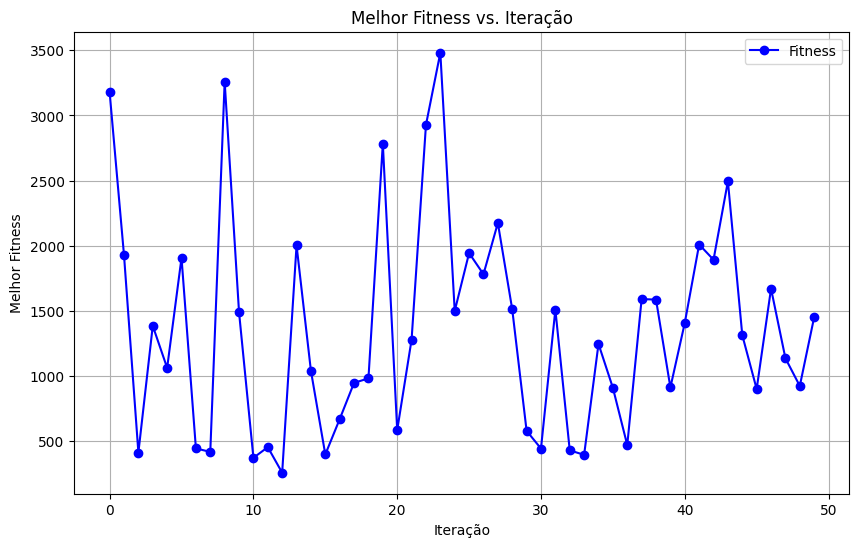

In [100]:
pso0 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.GLOBAL)
pso0.otimizar()
pso0.plotar_grafico_convergencia()


Iteração 50 | Melhor solução: [-22.88589761  -2.00742212  14.43009943] | Fitness: 83.4259327043428 | Histórico Fitness: [1990.2356181380917, 1091.982409574438, 1851.4002015093656, 438.53069536570314, 1399.3903415841914, 1526.2119874768523, 2237.465489228233, 3911.910853583429, 2118.1283838057584, 796.953235729769, 1896.2316994277, 2408.741785464976, 7064.4789856611515, 2456.8610252956705, 4259.4897374077955, 10118.018496282462, 5815.612235173749, 7411.260539927722, 869.4384687024324, 4456.7091025863065, 3543.155027517435, 2005.2943832867904, 149.11314361015565, 885.4722535957752, 524.9303498147327, 148.72687042963906, 2121.7227480176657, 234.32025063598235, 191.74693017187766, 2014.6677998197026, 820.4247464550075, 165.66132555114132, 1322.715836925743, 876.9909660227701, 2910.8943567750953, 846.0770121656324, 3257.920453843023, 1108.3036406631418, 83.4259327043428, 977.8140782645962, 2870.1590722008223, 583.0059288361698, 205.0873263459813, 132.0618060214572, 1285.1731611538341, 457.4

C:\Users\Pedro\AppData\Local\Temp\ipykernel_24912\4221234025.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3'])


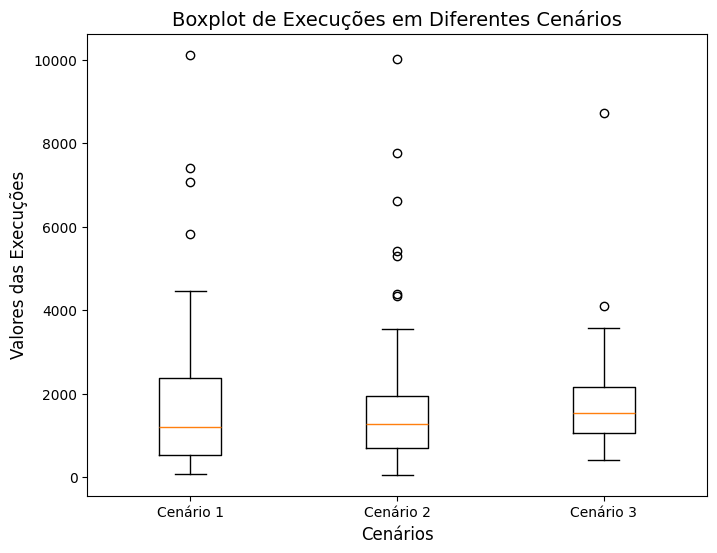

In [97]:
pso1 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.LOCAL_SOCIAL, 10)
pso1.otimizar()

pso2 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.LOCAL_GEOGRAFICA, 15)
pso2.otimizar()

pso3 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.GLOBAL)
pso3.otimizar()

cenario_1 = pso1.melhores_fitness
cenario_2 = pso2.melhores_fitness
cenario_3 = pso3.melhores_fitness

dados = [cenario_1, cenario_2, cenario_3]

# Criando o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3'])

# Adicionando título e rótulos aos eixos
plt.title('Boxplot de Execuções em Diferentes Cenários', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

# Mostrando o gráfico
plt.show()